# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from bs4 import BeautifulSoup
import re

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import Phrases

import spacy
from spacy.tokens import Doc
from spacy.lang.en.stop_words import STOP_WORDS

from tqdm import tqdm_notebook as tqdm
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
from scipy.spatial.distance import cosine

# DF Import and Process

In [2]:
ecom_df = pd.read_csv('data/ecommerce.csv', low_memory=False)
ecom_df = ecom_df[ecom_df.columns[:-20]]
ecom_df = ecom_df.dropna(subset=['product_description'])
brands = ['Shop.com', 'Overstock', 'walmart', 'Target', 'eBay']
ecom_df = ecom_df[ecom_df['source'].isin(brands)]

# NLP

## Pre-process

In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
def lemmatizer(doc):
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

def strip_html_tags(doc):
    soup = BeautifulSoup(doc.text, "html.parser")
    stripped_text = soup.get_text()
    return nlp.make_doc(stripped_text)

def remove_special_characters(doc, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', doc.text)
    text = re.sub("\s\s+", " ", text)
    return nlp.make_doc(text)

def remove_small(doc):
    doc = [token for token in doc if len(token) > 1]
    return doc

# def chop(doc):
#     words = [wordninja.split(token.text) for token in doc]
#     words = [item for sublist in words for item in sublist]
#     spaces = [True]*len(words)
#     doc = Doc(nlp.vocab, words=words, spaces=spaces)
#     return doc

def lower(doc):
    doc = [t.text for t in doc]
    doc = [token.lower() for token in doc if token != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(strip_html_tags,name='strip_html',first=True)
nlp.add_pipe(remove_special_characters,name='removespecchar')
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(lower,name='lower')
nlp.add_pipe(remove_small,name='remove_small')
nlp.add_pipe(remove_stopwords, name="stopwords")
nlp.pipe_names

['strip_html',
 'tagger',
 'parser',
 'ner',
 'lemmatizer',
 'removespecchar',
 'lower',
 'remove_small',
 'stopwords']

In [447]:
# custom stop lists
shipping = ['item', 'easy', 'power', 'free', 'inch', 'reader', 'ebay', 'listing', 'new', 'condition',
            'translation','seller', 'packaging', 'guarantee', 'result', 'shipping', 'ship', 'zip', 'code',
            'time', 'day', 'fastship', 'easybuy', 'unopened', 'undamaged']
image = ['width', 'font', 'margin', 'height', 'text', 'border', 'box', 'padding', 'background', 'color',
         'align', 'radius', 'important', 'shadow', 'solid', 'size', 'leave', 'line', 'px', 'heightpx',
         'widthpx', 'marginpx', 'rgba', 'pxborder', 'image', 'position', 'index', 'arial', 'li',  'sizepx',
         'center_contact', 'toppx', 'leftpx', 'rightpx', 'display', 'hide', 'helvetica', 'style', 'serif', 
         'mpicbanner', 'prodimg', 'paddingpx', 'photoadd', 'pxpadding', 'fff', 'block', 'bold', 'html', 'img', 
         'sub', 'importantfont', 'blockquote', 'menurow', 'pxfont', 'pxbox', 'weight', 'smail', 'pic', 'box',
         'blockfloat', 'borderpx', 'br', 'mobile_mobile', 'old_browser', 'tbody', 'smail_pic_box', 'mobilebox',
         'mmtable', 'mobile_selector', 'decoration', 'pxmargin' ,'pxcolor', 'overflow', 'mobile', 'selector',
         'browser', 'ccc', 'urlhttpsthemesgoogleusercontentcom', 'static', 'normal', 'src', 'formatwoff', 
         'leftmargin', 'importantwidthpx', 'alphaopacityopacity', 'leftborder', 'cimgtext',
         'figcaption', 'topnav_dadada', 'opacitymoz_opacity', 'relativez', 'opacity_ct', 'oimg', 'pttable',
         'urlhttpimagehostvendiocom','preview','verdanafont','verdana','seriffont','tx','family','active',
         'curiowarehouse','visit','al', 'transparent','urlhttpstoragegoogleapiscom','upload','listing','image',
         'imageupload','production','family','helveticafont','listing','image','orange','headerpng','sizepxfont',
         'boldmarginpx','heightpxtext','leftpadde','stretch','normalfont','logojpg','scroll','customizepaddingpx',
         'title', 'header','heightpxpadding','rightwidthpx','thumbimage','inforightfloat','rightwidthpx',
         'infotitlefont','infotext','clearfloat','clear','fltrt','fltlft','descriptioncolor','header','descriptionline',
         'contenttext','acolorddd','footnav','sellerinfo','sizepxline','hgroup','menu','policy','box','policy',
         'box','cursor','outline','opacity','ct','footer','header','transition','delay','user','edit','user',
         'edit','dash','eee','min','transition','child','attributestableall','clearfloat','clear',
         'rightmargin','sellerinfofloat','lovely','notebook','form','label','maincontent','mainimage',
         'infotitlefont','infotext','caption','outline','header','heightpxpadding','inforightfloat',
         'rightwidthpx','listing','image','orange','headerpng','bottompx','backgroundfff','colorfff','radiuspx',
         'new','arrival','mod','focus','show','mod','focus','list','category','tabtitle','opacity','item','show',
         'mod','focus','show','mod','focus','pic','hgroup','menu','footer','header','policy','box','policy','box',
         'cursor','outline','opacity','ct','transition','delay','user','edit','user','edit','dash','eee','min',
         'transition','child','attributestableall','underline',
 'sizepxcolortext',
 'filter',
 'true',
 'alphaimageloaderenabled',
 'dximagetransform',
 'microsoft',
 'sizingmethod',
 'progid',
 'faq',
 'frame',
 'narrow',
 'ds',
 'gif',
 'f',
 'gif',
 'scale',
 'srchttpimagehostvendiocom',
 'bg',
 'bl',
 'classes',
 'bg',
 'gld','policy',
 'box',
 'fix',
 'pub',
 'content',
 'space',
 'dbdbdb',
 'hotitemtitleoverflow',
 'zdiv',
 'slideshow',
 'childtext',
 'descdiv',
 'noneposition',
 'centercolor',
 'attributestable',
 'za',
 'close',
 'widthsetmax','mod',
 'focus',
 'show',
 'urlhttpwwwsavenet',
 'mod',
 'focus',
 'list',
 'new',
 'arrival',
 'hgmould',
 'focus',
 'switch',
 'nocil',
 'categories',
 'syfocusthumb',
 'mod',
 'focus',
 'pic',
 'item',
 'show',
 'muban',
 'button',
 'rgb',
 'rgbawebkit',
 'rgbaborder',
 'guyaran',
 'gan' ]
nationalities = ['italianoitalian' 'espaolspanish', 'svenskaswedish', 'norsknorwegian', 'magyarhungarian',
                 'rketurkish', 'inaslovak', 'bahasa', 'indonesiaindonesian', 'eskyczech', 'suomifinnish', 
                 'franaisfrench', 'franais', 'italiano', 'portugus', 'portugusportuguese', 'englishenglish', 
                 'nederlandsdutch', 'espaolspanish', 'espaol', 'italian', 'tvietnamese', 'english', 'sloven']
misc = ["\n", "\t", "urlhttpcsvkme", 'de', 'ulsuperthumbs', 'ul', 'es', 'specic', 'dcc', 'type', 'tab',
        'unused', 'urlhttpwwwsaatscommercecom', 'te_rsc', 'inline', 'superheadermenu', 'superwrapper','float',
        'ffffff', 'ulnavi', 'nav', 'pdt', 'ps', 'note', 'list', 'return', 'purchase', 'tr', 'center', 'link',
        'auto', 'user', 've', 'use', 'sans', 'td', 'webkit', 'etable', 'hotitemli', 'webkit', 'pointer',
        'inset', 'urlhttpimgphotoaddus', 'menutool', 'ofce', 'battleeld', 'right', 'unit', 'iter',
        'moreabout', 'policy', 'left', 'window', 'ti', 'ng', 'sm', 'lisuperthumbs', 'nd', 'apr', 'denitions', 
        'vi', 'romn', 'repeat', 'c', 'non', 'urlhttpdesignpushauctioncom', 'hover', 'unprinted', 'open', 
        'product', 'open', 'listerthe', 'applicable', 'holder', 'update', 'assume', 'pay', 'payment', 'tag', 
        'relative', 'absolute', 'view', 'revision', 'find', 'responsibility', 'specific', 'tool', 'good', 
        'croc', 'order', 'autotext', 'mm', 'feature', 'need', 'el', 'la', 'con', 'una', 'pera', 'en', 'upper',
        'like', 'set', 'help', 'para', 'thomas', 'design', 'include', 'provide', 'print', 'perfect', 'add',
        'high', 'fit', 'outsole', 'offer', 'look', 'allow', 'detail', 'accuracy', 'accessibility', 'brand', 
        'number', 'enjoy', 'er', 'ge', 'atm', 'ft', 'th', 'nbsp', 'basacc', 'qt', 'overall', 'wide', 'deep',
        'officially', 'strong', 'pull', 'bad', 'jazz', 'victorinox', 'rashbi', 'lauren', 'resalyte', 'anc',
        'popularity', 'rma', 'srlr', 'availability', 'ii', 'reh', 'tob', 'accell', 'mov', 'ness', 'cu', 'hproduct',
        'ada', 'citiz', 'ds', 'audience', 'ideo', 'wdth', 'droll', 'proliant', 'ron', 'furia', 'anc', 'jek', 'ev', 
        'll', 'unlikely', 'bid', 'sum', 'hplease', 'ralph', 'sick', 'yes', 'deca', 'etl', 'csa', 'ce', 'approve',
        'productdescription','aplus','feeder','seed','bird','tabledata','bird','feeder','aplus','em','em',
        'wild','bird','em','productdescription','descriptionline','contenttext','listing','image','dividegif',
        'form','label','customizecolor','infotitlecolorfe','coloreee','dividebackground','footnav',
        'divideheightpxmargin','footerlink','footerlink','footer','centerheightpxcolorccc','boldpadding',
        'bottompxtext','bothfont','sizepxheightline']

# My list of stop words.
stop_list = shipping + image + nationalities + misc

# Updates spaCy's default stop words list with my additional words. 
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

In [456]:
text_conv = 'mod_focus_show urlhttpwwwsavenet mod_focus_list new_arrival hgmould focus_switch nocil_categories syfocusthumb mod_focus_pic item_show muban button rgb rgbawebkit_rgbaborder guyaran_gan'

text_conv = [el.split('_') for el in text_conv.split()]
[item for sublist in text_conv for item in sublist]

['mod',
 'focus',
 'show',
 'urlhttpwwwsavenet',
 'mod',
 'focus',
 'list',
 'new',
 'arrival',
 'hgmould',
 'focus',
 'switch',
 'nocil',
 'categories',
 'syfocusthumb',
 'mod',
 'focus',
 'pic',
 'item',
 'show',
 'muban',
 'button',
 'rgb',
 'rgbawebkit',
 'rgbaborder',
 'guyaran',
 'gan']

In [459]:
text = ecom_df.product_description
docs = [doc for doc in nlp.pipe(tqdm(text.values), n_threads=-1, disable=['parser', 'ner'])]

bigram = Phrases(docs, min_count=6, threshold=45)
trigram = Phrases(bigram[docs], min_count=6, threshold=45)
docs = bigram[docs]

In [460]:
with open('SeaNMF/data/data.txt', 'w') as f:
    for _list in docs:
        for _string in _list:
            f.write(str(_string) + ' ')
        f.write('\n')

In [461]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(docs)
word_list = list(words.values())

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in docs]

tfidf = gensim.models.TfidfModel(corpus, id2word=words)
corpus_tfidf = tfidf[corpus]

corpus_sparse = gensim.matutils.corpus2csc(corpus)

## NMF

In [8]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [462]:
#obtain a NMF model.
nmf_model = NMF(n_components=30, random_state=99);
#fit the model
nmf_vec = nmf_model.fit_transform(corpus_sparse.T)

In [463]:
print("\nTopics in NMF model:")
print_top_words(nmf_model, word_list, 15)


Topics in NMF model:
Topic #0: handle cookware food pan lid heat skillet kitchen cast_iron nonstick surface cooking cook piece rachael_ray
Topic #1: coffee cup brew coffee_maker brewing espresso keurig single_serve flavor pack brewer filter coffeemaker way water
Topic #2: device port adapter audio connect cable hdmi usb phone video micro_usb mhl tv microphone support
Topic #3: pillow memory_foam support sleep contour shape neck cover comfort foam body polyester fill soft bed
Topic #4: case iphone protection protect phone layer scratch access device screen_protector leather snap hard samsung_galaxy screen
Topic #5: receive package contact business buyer address email delivery customer international feedback country date hour send
Topic #6: main temp_gall gall_main urlhttpimgyiwutalkcom_describe main_feat secimgs_main small main_tabs feat_fp main_temp gall_gall gall_thmb pad thumb tmid
Topic #7: game play system world player wii controller playstation experience video_game console gamer

## LDA

In [332]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=words,
                                           num_topics=10, 
                                           random_state=99,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

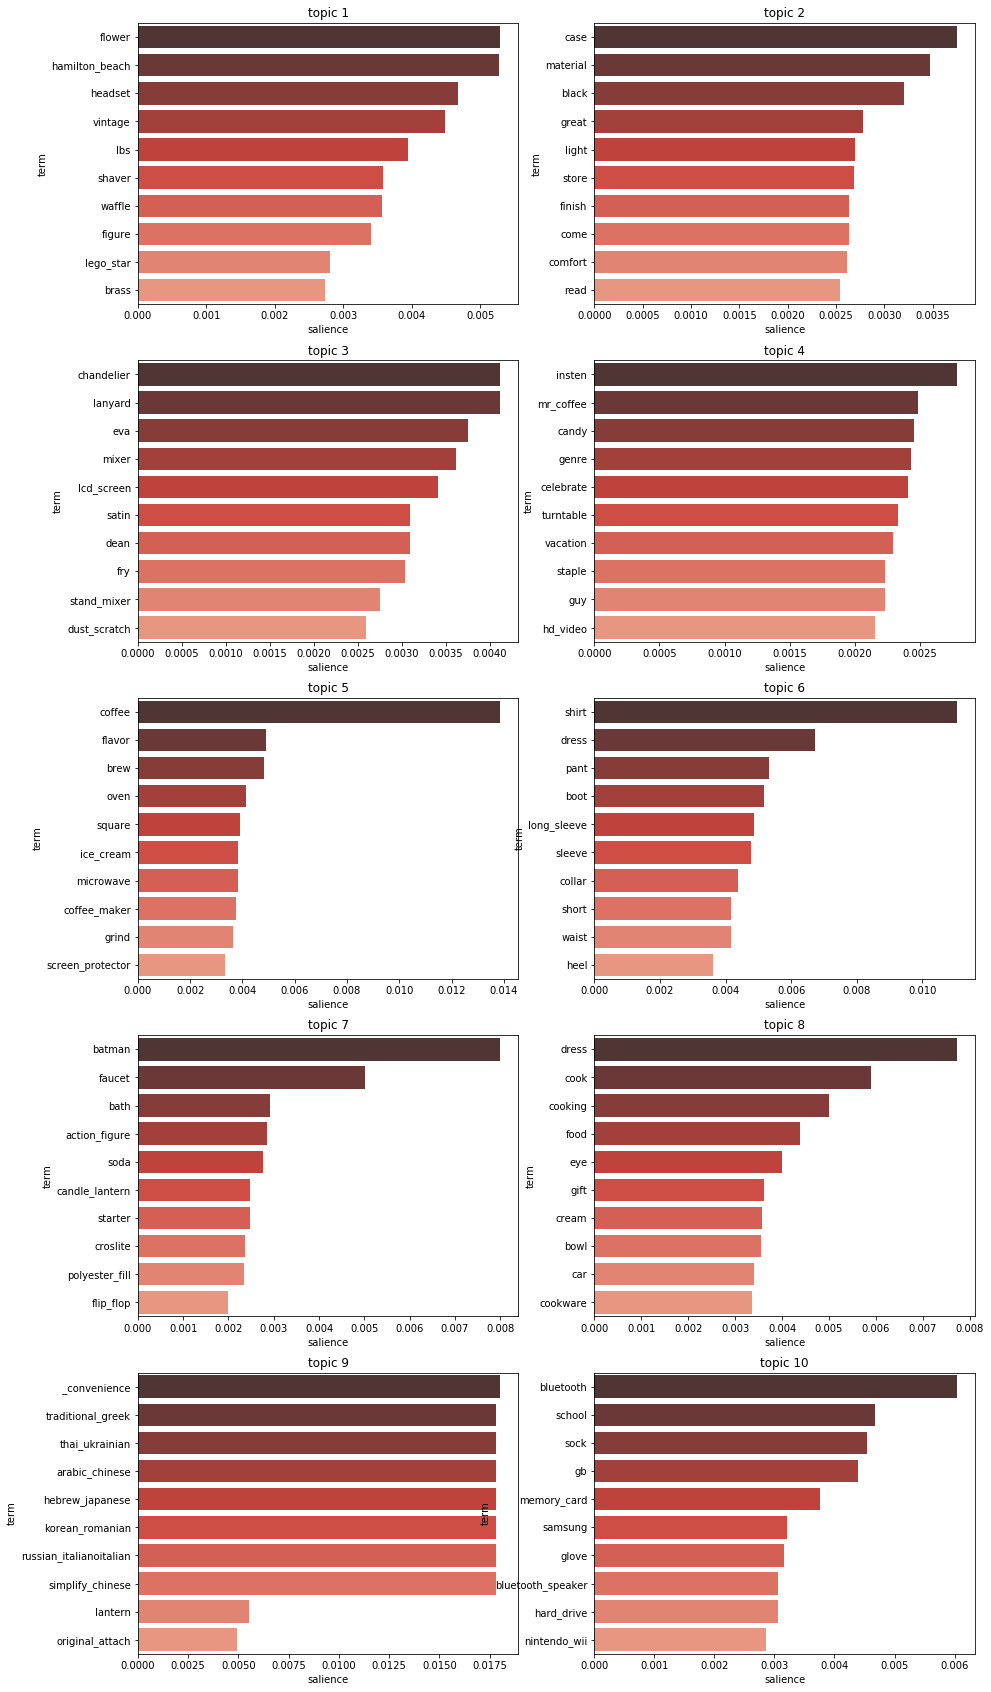

In [333]:
fiz=plt.figure(figsize=(15,30))
for i in range(10):
    df=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')
    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, palette='Reds_d')
    plt.xlabel('salience')
    
plt.show()

In [334]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=words, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print(f"PERPLEXITY: {lda_model.log_perplexity(corpus_tfidf)}") # a measure of how good the model is.
print(f"COHERENCE: {coherence_lda}")

PERPLEXITY: -11.076972554215722
COHERENCE: 0.5554886282647814


In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=num_topics, 
                                           random_state=99,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

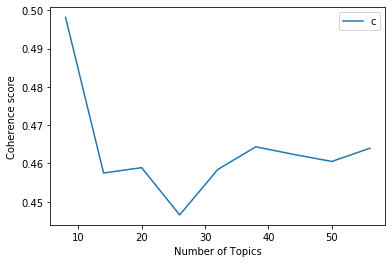

MODEL LIST: [<gensim.models.ldamodel.LdaModel object at 0x7f2bf8d3a128>, <gensim.models.ldamodel.LdaModel object at 0x7f2bf8d3a240>, <gensim.models.ldamodel.LdaModel object at 0x7f2c033339e8>, <gensim.models.ldamodel.LdaModel object at 0x7f2c03333b00>, <gensim.models.ldamodel.LdaModel object at 0x7f2bfba2dba8>, <gensim.models.ldamodel.LdaModel object at 0x7f2bf8da0128>, <gensim.models.ldamodel.LdaModel object at 0x7f2c08735e10>, <gensim.models.ldamodel.LdaModel object at 0x7f2c0adc7518>, <gensim.models.ldamodel.LdaModel object at 0x7f2c214d5320>]
COHERENCE VALUES: [0.49817881246158224, 0.45748073474515183, 0.4588871223894978, 0.44653846812147, 0.4583898892466336, 0.46432791802783935, 0.462341818133015, 0.46050817042398895, 0.46395846840895155]
Model performs best with 8 topics


In [199]:
limit=62; start=8; step=6;

model_list, coherence_values = compute_coherence_values(dictionary=words, 
corpus=corpus, texts=docs, start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence values"), loc='best')
plt.show()

topics = (np.argsort(coherence_values)[-1]*step)+start
print(f"MODEL LIST: {model_list}")
print(f"COHERENCE VALUES: {coherence_values}")
print(f"Model performs best with {topics} topics")

In [201]:
final_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=38, 
                                           random_state=99,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           minimum_probability = 0,
                                           per_word_topics=True)

## Corex

In [43]:
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

/home/danroth/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [126]:
corex_model = ct.Corex(n_hidden=20, words=word_list, seed=1, max_iter=200)
corex_model.fit(corpus_sparse.T, words=word_list, docs=text,
                anchors = [['coffee', 'cup'], 
                           ['cook', 'cooking'],
                           ['shirt','dress','waist','pant','dress_shirt','hem'],
                           ['charge','phone','speaker'],
                           ['shoe','heel','boot','sole','toe','insole','traction','leather','rain_boot','sneaker'],
                           ['gb','memory_card','video','wireless'],
                           ['necklace','pendant','sterling_silver','diamond','kt_gold','jewelry','earring','chain'],
                           ['case','samsung_galaxy','protect','screen_protector','case_apple','cell_phone','scratch','laptop_bump'],
                           ['skin','vacuum','eye_cream','vitamin','formula','moisturize','cocoa_butter','cream','dark_circle']], anchor_strength=3)

In [127]:
topics = corex_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: coffee,cup,cook,cooking,brew,food,cookware,ice_cream,skillet,lid
1: dress,shirt,waist,pant,dress_shirt,hem,jean,button,cotton,neckline
2: charge,speaker,sound,audio,charger,battery,headset,usb,device,bluetooth
3: shoe,heel,sole,boot,toe,insole,leather,traction,sneaker,rain_boot
4: gb,wireless,memory_card,video,mouse,camera,wireless_mouse,memory,hard_drive,router
5: necklace,pendant,sterling_silver,diamond,chain,jewelry,earring,kt_gold,heart_rate,chain_necklace
6: case,samsung_galaxy,screen_protector,protect,case_apple,scratch,cell_phone,laptop_bump,iphone,macbook_pro
7: skin,vacuum,eye_cream,vitamin,cocoa_butter,formula,moisturize,cream,dark_circle,fragrance
8: faucet,kitchen_faucet,american_standard,shakespeare,minecraft,fishing,swivel_spout,lever_handle,angler,single_lever
9: sunglass,ray_ban,lense,temple,polarized,frame,lens,uv_protection,ninja_turtles,teenage_mutant
10: knife,blade,tang,sheath,victorinox,hunt_knife,patio_umbrella,carbon_stainless,victorinox_swiss,uv
11: shaver,p

ValueError: shape mismatch: objects cannot be broadcast to a single shape

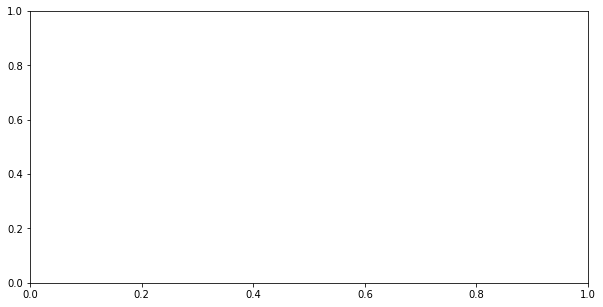

In [136]:
plt.figure(figsize=(10,5))
plt.bar(range(corex_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

## To Dataframe

In [476]:
with open('SeaNMF/seanmf_results/H.txt') as file:
    lines = [line.rstrip('\n') for line in file]
sea_weights = [[float(el) for el in line.split()] for line in lines]
sea_weights = [list(map(lambda x: round(x,5), i)) for i in sea_weights]

In [464]:
# Get topic weights
nmf_weights = []
for i, row_list in enumerate(nmf_vec):
    nmf_weights.append([w for w in row_list])
nmf_weights = [list(map(lambda x: round(x,5), i)) for i in nmf_weights]

In [204]:
# Get topic weights
lda_weights = []
for i, row_list in enumerate(final_model[corpus]):
    lda_weights.append([w for i, w in row_list[0]])
lda_weights = [list(map(lambda x: round(x,5), i)) for i in lda_weights]

In [477]:
topic_weights = sea_weights
# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

In [478]:
topic_prob = pd.DataFrame(topic_weights).fillna(0)
topic_label = pd.DataFrame(topic_num).fillna(0)
topic_vec = pd.concat([topic_prob,topic_label], axis=1)

In [479]:
product_df = pd.concat([ecom_df, topic_vec], axis=1)

topic_id = [f'topic{num}' for num in range(len(set(topic_num)))] + ['topic_label']
cols = product_df.columns[:-len(set(topic_num))-1].tolist() + topic_id 
product_df.columns = cols

product_df['score_sum'] = product_df.loc[:,'topic0':f'topic{len(set(topic_num))-1}'].sum(axis=1)
product_df.drop_duplicates(keep=False,inplace=True) 

In [480]:
pd.set_option('display.max_columns', None)
product_df.head()

_unit_id  relevance  relevance:variance  \
0  711158459.0       3.67               0.471   
1  711158460.0       4.00               0.000   
2  711158461.0       4.00               0.000   
4  711158463.0       3.33               0.471   
5  711158464.0       3.20               0.748   

                                       product_image  \
0  http://thumbs2.ebaystatic.com/d/l225/m/mzvzEUI...   
1  http://thumbs3.ebaystatic.com/d/l225/m/mJNDmSy...   
2  http://thumbs4.ebaystatic.com/d/l225/m/m10NZXA...   
4  http://thumbs3.ebaystatic.com/d/l225/m/mzvzEUI...   
5  http://thumbs4.ebaystatic.com/d/l225/m/mzvzEUI...   

                                        product_link  \
0  http://www.ebay.com/itm/Sony-PlayStation-4-PS4...   
1  http://www.ebay.com/itm/Sony-PlayStation-4-Lat...   
2  http://www.ebay.com/itm/Sony-PlayStation-4-PS4...   
4  http://www.ebay.com/itm/Sony-PlayStation-4-PS4...   
5  http://www.ebay.com/itm/Sony-PlayStation-4-PS4...   

                   product_price  \
0                        $329.98   
1                        $324.84   
2                        $324.83   
4  $308.00\nTrending at\n$319.99   
5                        $310.00   

                                       product_title          query rank  \
0  Sony PlayStation 4 (PS4) (Latest Model)- 500 G...  playstation 4    1   
1  Sony PlayStation 4 (Latest Model)- 500 GB Jet ...  playstation 4    2   
2    Sony PlayStation 4 PS4 500 GB Jet Black Console  playstation 4    3   
4  Sony PlayStation 4 (PS4) (Latest Model)- 500 G...  playstation 4    5   
5  Sony PlayStation 4 (PS4) (Latest Model)- 500 G...  playstation 4    6   

  source                                                url  \
0   eBay  http://www.ebay.com/sch/i.html?_from=R40&_trks...   
1   eBay  http://www.ebay.com/sch/i.html?_from=R40&_trks...   
2   eBay  http://www.ebay.com/sch/i.html?_from=R40&_trks...   
4   eBay  http://www.ebay.com/sch/i.html?_from=R40&_trks...   
5   eBay  http://www.ebay.com/sch/i.html?_from=R40&_trks...   

                                 product_description   topic0   topic1  \
0  The PlayStation 4 system opens the door to an ...  0.76573  0.69025   
1  The PlayStation 4 system opens the door to an ...  0.76573  0.69025   
2  The PlayStation 4 system opens the door to an ...  0.76573  0.69025   
4  The PlayStation 4 system opens the door to an ...  0.76573  0.69025   
5  The PlayStation 4 system opens the door to an ...  0.76573  0.69025   

   topic2  topic3  topic4  topic5  topic6  topic7  topic8  topic9  topic10  \
0     0.0     0.0     0.0     0.0     0.0     0.0  8.9066     0.0      0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0  8.9066     0.0      0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0  8.9066     0.0      0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0  8.9066     0.0      0.0   
5     0.0     0.0     0.0     0.0     0.0     0.0  8.9066     0.0      0.0   

   topic11  topic12  topic13  topic14  topic15  topic16  topic17  topic18  \
0      0.0      0.0      0.0      0.0      0.0      0.0  0.11309      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0  0.11309      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0  0.11309      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0  0.11309      0.0   
5      0.0      0.0      0.0      0.0      0.0      0.0  0.11309      0.0   

   topic19  topic20  topic21  topic22  topic23  topic24  topic25  topic26  \
0      0.0      0.0      0.0      0.0      0.0      0.0  0.17336      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0  0.17336      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0  0.17336      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0  0.17336      0.0   
5      0.0      0.0      0.0      0.0      0.0      0.0  0.17336      0.0   

   topic27  topic28  topic29  topic30  topic31  topic32  topic33  topic34  \
0      0.0      0.0      0.0  2.44761      0.0      0.0      0.0   

In [481]:
with open("data/product_df.pkl", 'wb') as openfile:
    pickle.dump(product_df, openfile)

35 topics seanmf best

# Plot

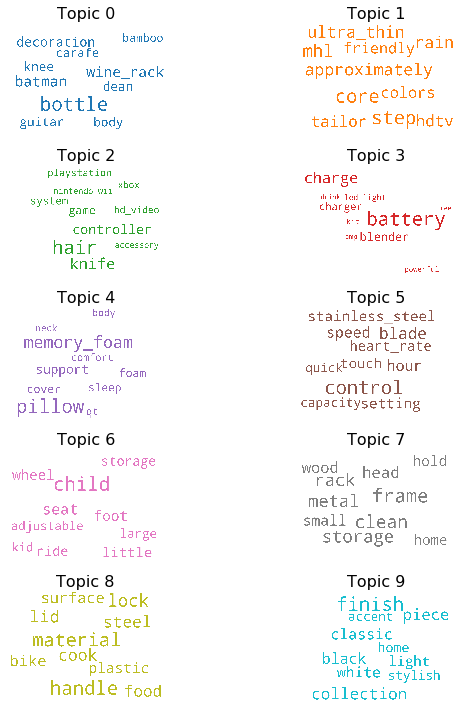

In [55]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=nlp.Defaults.stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10', margin = 3, min_font_size=1,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = final_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

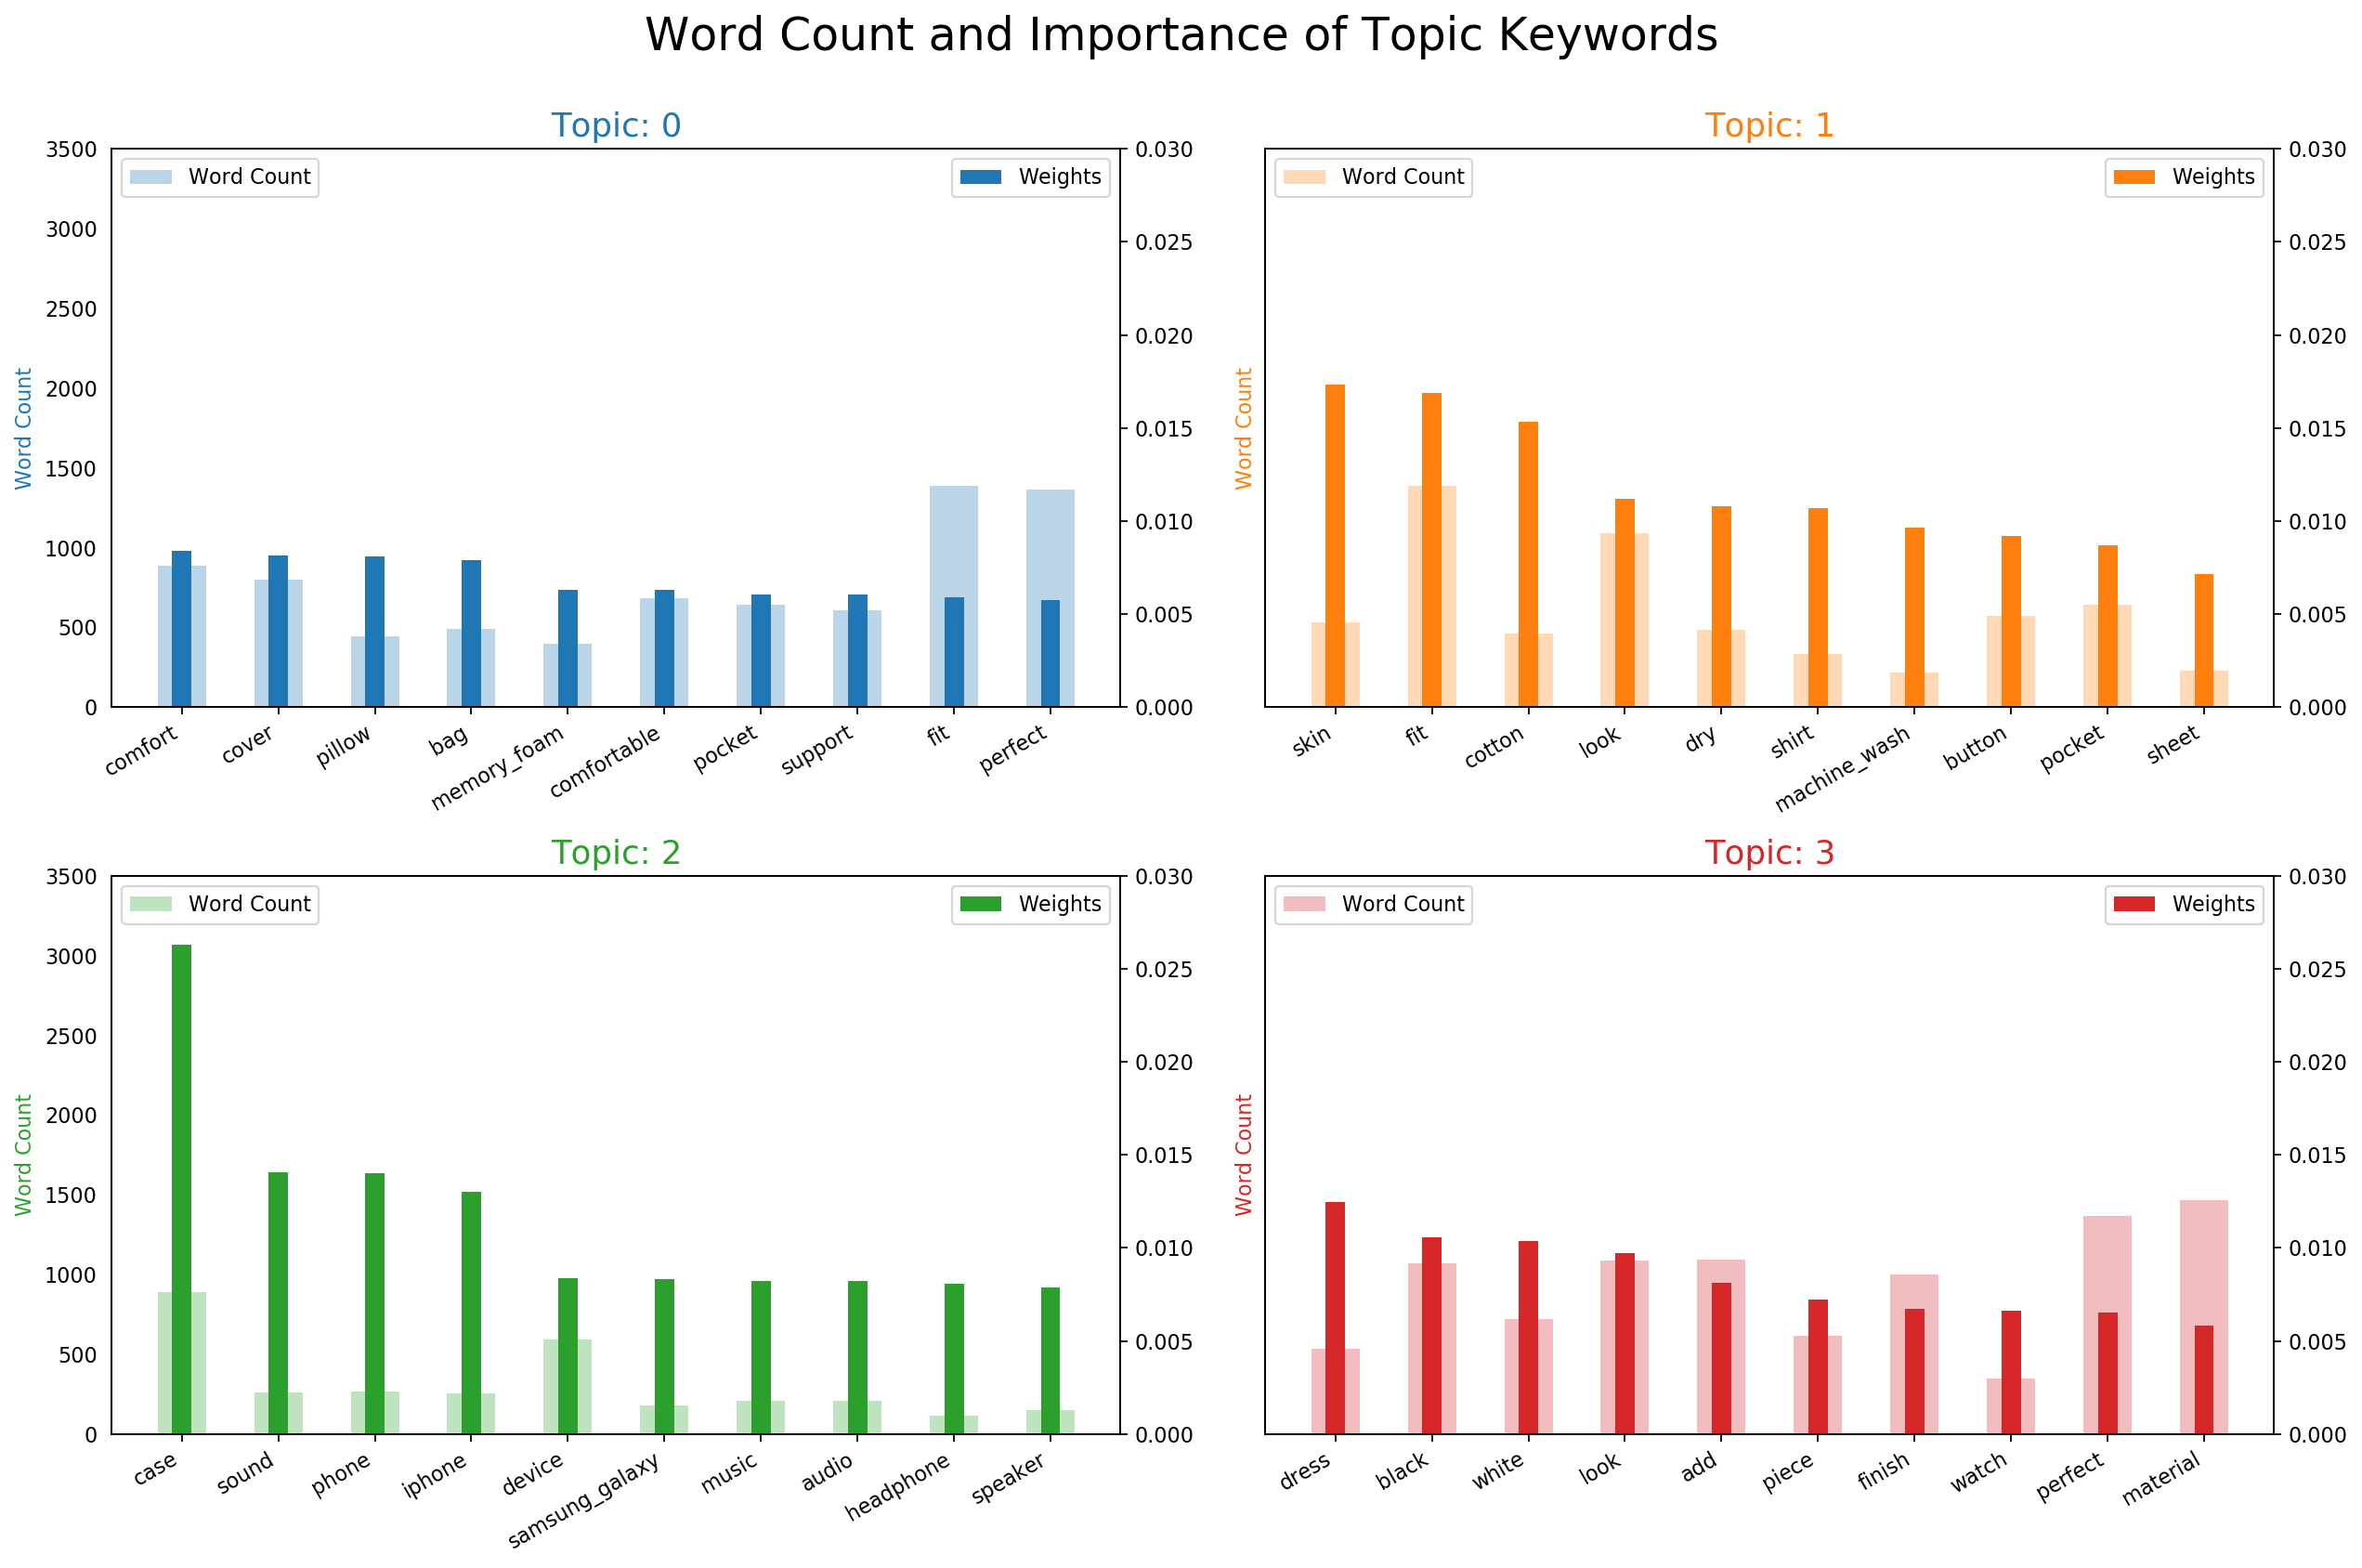

In [47]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 2.857s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.098146
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.153458
[t-SNE] KL divergence after 1000 iterations: 1.533869


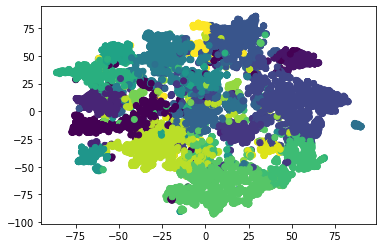

In [59]:
tsne = TSNE(n_components=2, verbose=1, random_state=0)
X_tsne = tsne.fit_transform(arr)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=topic_num)
plt.show()

In [119]:
import plotly.offline as off
off.init_notebook_mode(connected=False) # allows for offline mode
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.io as pio

fig = go.Figure(data=[go.Scatter(
    x = X_tsne[:, 0],
    y = X_tsne[:, 1],
    mode='markers', showlegend=True,
    marker=dict(
        color=topic_num,
        colorscale='Viridis',
        line_width=1
    )
)])

fig2 = [dict(
  type = 'scatter',
  x = X_tsne[:, 0],
  y = X_tsne[:, 1],
  mode = 'markers',
  transforms = [dict(
    type = 'groupby',
    groups = topic_num,
    styles = [
        dict(target = 0, value = dict(marker = dict(color = 'blue'))),
        dict(target = 1, value = dict(marker = dict(color = 'red'))),
        dict(target = 2, value = dict(marker = dict(color = 'black')))
    ]
  )]
)]


off.iplot(fig2)

# Product Search

In [181]:
def find_item(search):
    topic = int(search)
    sort = 'topic' + search
    select = products[products.topic_label == topic].dropna()
    try:
    	out = select.sort_values(sort, ascending=False)
    	status=True
    except:
	    out = 0
	    status = False
    return out, status

In [442]:
check = 7
product_df['topic_ratio'] = product_df[f'topic{check}']/product_df.score_sum
product_df[product_df.topic_label == check].dropna().sort_values('topic_ratio', ascending=False)[:10]

_unit_id  relevance  relevance:variance  \
9307   711167775.0       4.00               0.000   
0      711158459.0       3.67               0.471   
2      711158461.0       4.00               0.000   
4      711158463.0       3.33               0.471   
5      711158464.0       3.20               0.748   
7      711158466.0       4.00               0.000   
1      711158460.0       4.00               0.000   
19760  711178261.0       3.20               0.748   
17301  711175793.0       2.33               0.471   
17299  711175791.0       1.67               0.471   

                                           product_image  \
9307   http://edge.shop.com/ccimg.shop.com/op/8127300...   
0      http://thumbs2.ebaystatic.com/d/l225/m/mzvzEUI...   
2      http://thumbs4.ebaystatic.com/d/l225/m/m10NZXA...   
4      http://thumbs3.ebaystatic.com/d/l225/m/mzvzEUI...   
5      http://thumbs4.ebaystatic.com/d/l225/m/mzvzEUI...   
7      http://thumbs4.ebaystatic.com/d/l225/m/mTZYG5N...   
1      http://thumbs3.ebaystatic.com/d/l225/m/mJNDmSy...   
19760  http://i.walmartimages.com/i/p/00/07/35/27/01/...   
17301  http://i.walmartimages.com/i/mp/I5/5P/Bb/VH/u0...   
17299  http://i.walmartimages.com/i/mp/I6/3P/Bb/U7/Z0...   

                                            product_link  \
9307   http://www.shop.com/AG+Anti+Glare+Screen+Prote...   
0      http://www.ebay.com/itm/Sony-PlayStation-4-PS4...   
2      http://www.ebay.com/itm/Sony-PlayStation-4-PS4...   
4      http://www.ebay.com/itm/Sony-PlayStation-4-PS4...   
5      http://www.ebay.com/itm/Sony-PlayStation-4-PS4...   
7      http://www.ebay.com/itm/Sony-PlayStation-4-500...   
1      http://www.ebay.com/itm/Sony-PlayStation-4-Lat...   
19760  http://www.walmart.com/ip/Mainstays-Large-3-Dr...   
17301  http://www.walmart.com/ip/Converse-CT-Double-T...   
17299  http://www.walmart.com/ip/Converse-Star-Player...   

                       product_price  \
9307                 $13.99 - $23.23   
0                            $329.98   
2                            $324.83   
4      $308.00\nTrending at\n$319.99   
5                            $310.00   
7                            $299.99   
1                            $324.84   
19760              $26.24\n-\n$35.92   
17301                         $15.99   
17299                         $26.99   

                                           product_title  \
9307   AG+ Anti-Glare Screen Protector for Samsung Ga...   
0      Sony PlayStation 4 (PS4) (Latest Model)- 500 G...   
2        Sony PlayStation 4 PS4 500 GB Jet Black Console   
4      Sony PlayStation 4 (PS4) (Latest Model)- 500 G...   
5      Sony PlayStation 4 (PS4) (Latest Model)- 500 G...   
7      Sony PlayStation 4 500GB, Dualshock Wireless C...   
1      Sony PlayStation 4 (Latest Model)- 500 GB Jet ...   
19760            Mainstays Kids Large 3-Drawer Wide Cart   
17301  Converse CT Double Tongue Youth Girls Size 12 ...   
17299  Converse Star Player Ox Mens Converse Bla Snea...   

                          query rank    source  \
9307   screen protector samsung    8  Shop.com   
0                 playstation 4    1      eBay   
2                 playstation 4    3      eBay   
4                 playstation 4    5      eBay   
5                 playstation 4    6      eBay   
7                 playstation 4    8      eBay   
1                 playstation 4    2      eBay   
19760           storage drawers   14   walmart   
17301        converse high tops   10   walmart   
17299        converse high tops    8   walmart   

                                                     url  \
9307   http://www.shop.com/search/screen protector sa...   
0      http://www.ebay.com/sch/i.html?_from=R40&_trks...   
2      http://www.ebay.com/sch/i.html?_from=R40&_trks...   
4      http://www.ebay.com/sch/i.html?_from=R40&_trks...   
5      http://www.ebay.com/sch/i.html?_from=R40&_trks...   
7      http://www.ebay.com/sch/i.html?_from=R40&_trks...   
1      http://www.ebay.com/sch/